### Import packages

In [6]:
from Bio import SeqIO
import pylab
import os
import numpy as np

### The block below takes a fasta inputted and displays a histogram showing the sequence length distribution within the fasta.

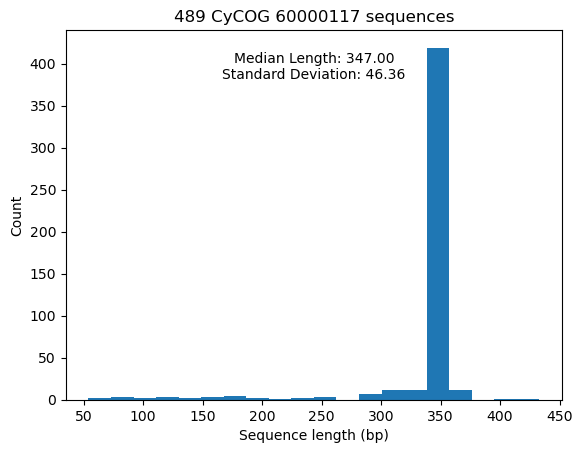

In [7]:

# Define the FASTA file path
fasta_file_path = "../1-get_cycog/data/CyCOG_60000117.prfg.faa"  # Add your FASTA file path here

# Extract the number before the first dot in the file name
cy_cog_number = os.path.basename(fasta_file_path).split("_")[1].split(".")[0]

# Parse the FASTA file and get sequence lengths
sizes = [len(rec) for rec in SeqIO.parse(fasta_file_path, "fasta")]

# Calculate median and standard deviation
median_length = np.median(sizes)
std_dev = np.std(sizes)

# Plot histogram
pylab.hist(sizes, bins=20)
pylab.title(f"{len(sizes)} CyCOG {cy_cog_number} sequences")
pylab.xlabel("Sequence length (bp)")
pylab.ylabel("Count")

# Annotate median and standard deviation on the histogram
pylab.text(0.5, 0.9, f'Median Length: {median_length:.2f}\nStandard Deviation: {std_dev:.2f}',
           horizontalalignment='center', verticalalignment='center', transform=pylab.gca().transAxes)

pylab.show()


### The block below makes a new fasta, filtering out sequences outside of one standard deviation from the median length.

In [12]:

# Define input file path
input_fasta_path = "../1-get_cycog/data/CyCOG_60000117.prfg.faa"

# Extract CyCOG number from the input file path
cy_cog_number = os.path.basename(input_fasta_path).split("_")[1].split(".")[0]

# Define output file path based on CyCOG number
output_fasta_path = f"filtered_sequences_{cy_cog_number}.fasta"

# Parse the input FASTA file and calculate median and standard deviation
sequences = []
for seq_record in SeqIO.parse(input_fasta_path, "fasta"):
    sequences.append(seq_record)
sequence_lengths = np.array([len(seq) for seq in sequences])
median_length = np.median(sequence_lengths)
std_dev = np.std(sequence_lengths)

# Filter sequences based on one standard deviation from the median
filtered_sequences = [seq for seq in sequences if len(seq) >= median_length - std_dev and len(seq) <= median_length + std_dev]

# Write filtered sequences to the output FASTA file
with open(output_fasta_path, "w") as output_file:
    SeqIO.write(filtered_sequences, output_file, "fasta")



### The block below makes a new histogram with the new fasta and saves it. It also deletes the fasta output.

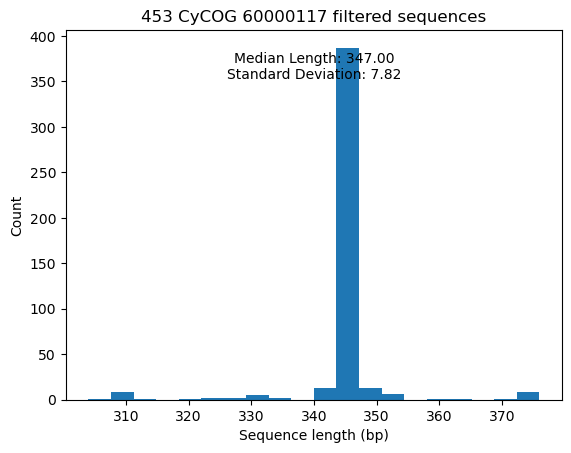

In [13]:
# Extract the cycog number for the histogram title and name
cy_cog_number = os.path.basename(output_fasta_path).split("_")[2].split(".")[0]

# Parse the FASTA file and get sequence lengths
sizes = [len(rec) for rec in SeqIO.parse(fasta_file_path, "fasta")]

# Calculate median and standard deviation
median_length = np.median(sizes)
std_dev = np.std(sizes)

# Plot histogram
pylab.hist(sizes, bins=20)
pylab.title(f"{len(sizes)} CyCOG {cy_cog_number} filtered sequences")
pylab.xlabel("Sequence length (bp)")
pylab.ylabel("Count")

# Annotate median and standard deviation on the histogram
pylab.text(0.5, 0.9, f'Median Length: {median_length:.2f}\nStandard Deviation: {std_dev:.2f}',
           horizontalalignment='center', verticalalignment='center', transform=pylab.gca().transAxes)

# Save the histogram output inside the "data" directory
output_histogram_path = os.path.join("data", f"{cy_cog_number}_hist.png")
pylab.savefig(output_histogram_path, bbox_inches='tight')

pylab.show()
os.remove(output_fasta_path) #This removes the fasta created in the last block, in order to run this block again you need to run the previous block first.
